# CMS GIWAXS plotting notebook - plotting single images from loaded zarr datasets
# Wenhan Samples GIWAXS CMS 2023C3?

## Imports

In [42]:
# Imports:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import xarray as xr
from tqdm.auto import tqdm

# Choose a colormap:
cmap = plt.cm.turbo
cmap.set_bad('black')

## Define & check paths

In [2]:
def select_attrs(data_arrays_iterable, selected_attrs_dict):
    """
    Selects data arrays whose attributes match the specified values.

    Parameters:
    data_arrays_iterable: Iterable of xarray.DataArray objects.
    selected_attrs_dict: Dictionary where keys are attribute names and 
                         values are the attributes' desired values.

    Returns:
    List of xarray.DataArray objects that match the specified attributes.
    """    
    sublist = list(data_arrays_iterable)
    
    for attr_name, attr_values in selected_attrs_dict.items():
        sublist = [da for da in sublist if da.attrs[attr_name] in attr_values]
                
    return sublist

def fold_image(data_array, fold_axis, progress_bar=False):
    """
    Method to fold image along a specified axis.
    
    Parameters:
    - data_array (xarray DataArray): The DataArray to fold
    - fold_axis (str): The axis along which to fold the image
    
    Returns:
    - xarray DataArray: The folded image
    """
    # Filter data for fold_axis >= 0 and fold_axis <= 0
    positive_data = data_array.where(data_array[fold_axis] >= 0, drop=True)
    negative_data = data_array.where(data_array[fold_axis] <= 0, drop=True)
    
    # Reverse negative_data for easier comparison
    negative_data = negative_data.reindex({fold_axis: negative_data[fold_axis][::-1]})
    
    # Find the maximum coordinate of the shorter quadrant (positive_data)
    max_positive_coord = float(positive_data[fold_axis].max())
    
    # Find the equivalent coordinate in the negative_data
    abs_diff = np.abs(negative_data[fold_axis].values + max_positive_coord)
    
    # Minimize the difference
    min_diff_idx = np.argmin(abs_diff)
    
    # Check if the lengths are equivalent
    len_pos = len(positive_data[fold_axis])
    len_neg = len(negative_data[fold_axis][:min_diff_idx+1])
    
    if len_pos != len_neg:
        # Adjust the coordinate range for negative_data
        for i in range(1, 4):  # Check 3 neighbors
            new_idx = min_diff_idx + i
            len_neg = len(negative_data[fold_axis][:new_idx+1])
            if len_pos == len_neg:
                min_diff_idx = new_idx
                break
                
    # Crop the negative_data to match positive_data length
    negative_data_cropped = negative_data.isel({fold_axis: slice(0, min_diff_idx+1)})
    
    # Prepare the new data array
    new_data = xr.zeros_like(positive_data)
    
    # Fold the image
    if progress_bar:
        for i in tqdm(range(len(positive_data[fold_axis]))):
            pos_val = positive_data.isel({fold_axis: i}).values
            neg_val = negative_data_cropped.isel({fold_axis: i}).values

            # Pixel comparison and choosing 
            new_data[i] = np.where(((pos_val == 0) | (np.isnan(pos_val))) & (neg_val > 1-1e-6),
                                   neg_val, 
                                   pos_val)
    else:
        for i in range(len(positive_data[fold_axis])):
            pos_val = positive_data.isel({fold_axis: i}).values
            neg_val = negative_data_cropped.isel({fold_axis: i}).values

            # Pixel comparison and choosing 
            new_data[i] = np.where(((pos_val == 0) | (np.isnan(pos_val)) | (pos_val < 2)) & (neg_val > 0.001),
                                   neg_val, 
                                   pos_val) 
            
            # # Pixel comparison and averaging
            # new_data[i] = np.where(
            #     (pos_val > 0) & (neg_val > 0), 
            #     (pos_val + neg_val) / 2,
            #     np.where(((pos_val == 0) | (np.isnan(pos_val))) & (neg_val > 0),
            #              neg_val, 
            #              pos_val)
            # )


        
    # Append residual data from the longer quadrant if exists
    if len(negative_data[fold_axis]) > min_diff_idx+1:
        residual_data = negative_data.isel({fold_axis: slice(min_diff_idx+1, None)})
        residual_data[fold_axis] = np.abs(residual_data[fold_axis])
        new_data = xr.concat([new_data, residual_data], dim=fold_axis)
        
    # Update data_array with the folded image
    data_array = new_data.sortby(fold_axis)
    
    # Inherit coordinates and metadata attributes from the original data_array
    data_array.attrs = data_array.attrs.copy()
    data_array.attrs['fold_axis'] = fold_axis  # Add 'fold_axis' attribute

    # Ensure all original coordinates are retained in the new data_array
    for coord in data_array.coords:
        if coord not in data_array.coords:
            data_array = data_array.assign_coords({coord: data_array[coord]})

    return data_array

In [5]:
# I like pathlib for its readability & checkability, it's also necessary for the loadSeries function later on
# Replace the paths with the ones relevant to your data, you can use the ".exists()" method to make sure you defined a path correctly
userPath = pathlib.Path('/nsls2/users/alevin')
propPath = pathlib.Path('/nsls2/data/cms/proposals/2023-3/pass-311415')
zarrsPath = propPath.joinpath('AL_processed_data/zarrs/bcy673')
outPath = propPath.joinpath('AL_processed_data/CS-SAMseries')

In [7]:
# List zarrs
sorted([f.name for f in zarrsPath.iterdir()])  # a way to list just the filenames and not the whole path

['CS_caked_stitched.zarr',
 'CS_raw_stitched.zarr',
 'CS_recip_stitched.zarr',
 'fix_caked_stitched.zarr',
 'fix_raw_stitched.zarr',
 'fix_recip_stitched.zarr',
 'var_caked_stitched.zarr',
 'var_raw_stitched.zarr',
 'var_recip_stitched.zarr']

## Cartesian plots

### Load dataset(s)

In [8]:
filename = 'CS_recip_stitched.zarr'
DS = xr.open_zarr(zarrsPath.joinpath(filename))
DS = DS.where(DS>1e-6)
DS

<xarray.Dataset>
Dimensions:  (q_z: 1073, q_xy: 981)
Coordinates:
  * q_xy     (q_xy) float64 -1.913 -1.909 -1.905 -1.901 ... 2.104 2.108 2.112
  * q_z      (q_z) float64 -1.648 -1.644 -1.64 -1.636 ... 2.613 2.617 2.621
Data variables: (12/72)
    1306990  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1306991  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1306992  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1306993  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1306998  (q_z, q_xy) float32 dask.array<chunksize=(269, 491), meta=np.ndarray>
    1306999  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    ...       ...
    1307193  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1307194  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1307199  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1307200  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1307201  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1307202  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>

### 2D reciprocal space images

In [15]:
# 2D reciprocal space cartesian plots
qxy_min = -1.1
qxy_max = 2.1
qz_min = 0
qz_max = 2.2


savePath = outPath.joinpath('recip_plots_v1')

# selected_attrs_dict = {'incident_angle':['th0.080', 'th0.140']}
# selected_attrs_dict = {'material': ['Y6'], 'solvent': ['CB']}
# selected_attrs_dict = {'sampleid': ['CS1']}
selected_attrs_dict = {}

selected_DAs = select_attrs(DS.data_vars.values(), selected_attrs_dict)
for DA in tqdm(selected_DAs):
    # Slice data for selected q ranges (will need to rename q_xy if dimensions are differently named)
    sliced_DA = DA.sel(q_xy=slice(qxy_min, qxy_max), q_z=slice(qz_min, qz_max))
    
    real_min = float(sliced_DA.compute().quantile(0.05))
    cmin = 1 if real_min < 1 else real_min

    cmax = float(sliced_DA.compute().quantile(0.997))   
    
    # Plot
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), interpolation='antialiased', figsize=(5.5,3.3))
    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)
    ax.axes.set(aspect='equal', title=f'Cartesian Plot: {DA.sampleid}, {float(DA.incident_angle[2:])}° Incidence',
                xlabel='q$_{xy}$ [Å$^{-1}$]', ylabel='q$_z$ [Å$^{-1}$]')
    ax.figure.set(tight_layout=True, dpi=130)
    
    ax.figure.savefig(savePath.joinpath(f'{DA.sampleid}_qxy{qxy_min}to{qxy_max}_qz{qz_min}to{qz_max}_{DA.incident_angle}.png'), dpi=150)

    # plt.show()
    plt.close('all')

  0%|          | 0/72 [00:00<?, ?it/s]

In [216]:
# # Yoneda peak check
# qxy_min = 0.22
# qxy_max = 2
# qz_min = -0.01
# qz_max = 0.05

# selected_DAs = select_attrs(DS.data_vars.values(), selected_attrs_dict)
# for DA in tqdm(selected_DAs):
#     # Slice data for selected q ranges (will need to rename q_xy if dimensions are differently named)
#     sliced_DA = DA.sel(q_xy=slice(qxy_min, qxy_max), q_z=slice(qz_min, qz_max))
#     qz_integrated_DA = sliced_DA.sum('q_xy')
    
#     # Plot
#     qz_integrated_DA.plot.line(label=DA.incident_angle)
    
# plt.legend()
# plt.grid(visible=True, which='major', axis='x')
# plt.show()

In [ ]:
# # A way to save data as csv files
# for DA in tqdm(DS.data_vars.values()):
#     # qxy columns, qz rows
#     DA.to_pandas().to_csv(outPath.joinpath('PM6-Y6_waxs', f'cartesian-2D_{DA.polymer}-{DA.weight_percent}_{DA.incident_angle}_{DA.scan_id}.csv'))

### 1D Qxy or Qz integrated lincuts

## Polar plots

### Load dataset

In [43]:
filename = 'CS_caked_stitched.zarr'
DS = xr.open_zarr(zarrsPath.joinpath(filename))
DS = DS.where(DS>1e-6)
DS

<xarray.Dataset>
Dimensions:  (chi: 180, qr: 1000)
Coordinates:
  * chi      (chi) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * qr       (qr) float64 0.0009976 0.00426 0.007523 ... 3.254 3.257 3.26
Data variables: (12/72)
    1306990  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1306991  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1306992  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1306993  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1306998  (chi, qr) float32 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1306999  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    ...       ...
    1307193  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1307194  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1307199  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1307200  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1307201  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>
    1307202  (chi, qr) float64 dask.array<chunksize=(90, 500), meta=np.ndarray>

In [44]:
### Apply a sin chi correction
sin_chi_DA = np.sin(np.radians(np.abs(DS.chi)))

corr_DS = DS.copy()
# corr_DS = corr_DS * sin_chi_DA  # This works mathematically, but does not preserve attributes
for var in corr_DS.data_vars:
    corrected = corr_DS[var] * sin_chi_DA
    corr_DS[var].values = corrected.values
    
corr_DS

<xarray.Dataset>
Dimensions:  (chi: 180, qr: 1000)
Coordinates:
  * chi      (chi) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * qr       (qr) float64 0.0009976 0.00426 0.007523 ... 3.254 3.257 3.26
Data variables: (12/72)
    1306990  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1306991  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1306992  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1306993  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1306998  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1306999  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    ...       ...
    1307193  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1307194  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1307199  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1307200  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1307201  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    1307202  (chi, qr) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [45]:
### Fold sin(chi) corrected dataset

folded_corr_DAs = []
for DA in tqdm(corr_DS.data_vars.values()):
    folded_corr_DAs.append(fold_image(DA, 'chi'))

  0%|          | 0/72 [00:00<?, ?it/s]

### 2D caked images

#### Unfolded raw(chi) intensity

In [21]:
# Polar plots, for raw(chi) intensities

# Set chi range: Full range
chi_min = None
chi_max = None
q_min = None
q_max = None

savePath = outPath.joinpath('caked_plots_v1')

# selected_attrs_dict = {'incident_angle':['th0.080', 'th0.140']}
# selected_attrs_dict = {'material': ['PM6']}
selected_attrs_dict = {}

selected_DAs = select_attrs(DS.data_vars.values(), selected_attrs_dict)
    
for DA in tqdm(selected_DAs):
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max), qr=slice(q_min, q_max))
    
    # Set color limits
    real_min = float(sliced_DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min

    cmax = float(sliced_DA.compute().quantile(0.995))       
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), figsize=(5,4), interpolation='antialiased')  # plot, optional parameter interpolation='antialiased' for image smoothing

    ax.axes.set(title=f'Polar plot: {DA.sampleid}, $\\alpha_i$ = {float(DA.incident_angle[2:])}°, raw intensity')

    ax.colorbar.set_label('Raw intensity [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    ax.figure.savefig(savePath.joinpath(f'rawchi_{DA.sampleid}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)

    # plt.show()  # Comment to mute plotting output
    plt.close('all')

  0%|          | 0/72 [00:00<?, ?it/s]

#### Folded raw(chi) intensity

In [ ]:
# Polar plots, for FOLDED raw(chi) intensities

# Set chi range: Full range
chi_min = None
chi_max = None
q_min = None
q_max = None

savePath = outPath.joinpath('PM6-Y6series/caked_plots_v1')

selected_attrs_dict = {}
selected_DAs = select_attrs(DS.data_vars.values(), selected_attrs_dict)
    
for DA in tqdm(selected_DAs):
    DA = fold_image(DA, 'chi')

    # Set color limits
    real_min = float(DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min

    cmax = float(DA.compute().quantile(0.995))  
    
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max), qr=slice(q_min, q_max))     
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), figsize=(5,4), interpolation='antialiased')  # plot, optional parameter interpolation='antialiased' for image smoothing
    ax.axes.set(title=f'Folded Polar Plot: {DA.material} {DA.solvent} {DA.rpm}, {float(DA.incident_angle[2:])}° Incidence, Raw Intensity')
    ax.colorbar.set_label('Raw Intensity [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    plt.show()  # Comment to mute plotting output
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    # ax.figure.savefig(savePath.joinpath(f'rawchi-folded_{DA.material}-{DA.solvent}-{DA.rpm}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')

#### Unfolded sin(chi) intensity

In [ ]:
# Polar plots, for sin(chi) intensities

# Set chi range: Full range
chi_min = -90
chi_max = 90
q_min = None
q_max = None

savePath = outPath.joinpath('A1-3set_waxs/caked_plots_v1')
    
for DA in tqdm(selected_corr_DAs):
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max), qr=slice(q_min, q_max))
    
    # Set color limits
    real_min = float(sliced_DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min

    cmax = float(sliced_DA.compute().quantile(0.995))       
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), figsize=(5,4), interpolation='antialiased')  # plot, optional parameter interpolation='antialiased' for image smoothing
    ax.axes.set(title=f'Polar Plot: {DA.film}, {float(DA.incident_angle[2:])}° Incidence, sin($\chi$) Corrected')
    ax.colorbar.set_label('Intensity * sin($\chi$) [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    plt.show()  # Comment to mute plotting output
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    # ax.figure.savefig(savePath.joinpath(f'sinchi_{DA.film}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')

#### Folded sin(chi) intensity

In [33]:
%matplotlib widget

In [40]:
plt.close('all')

  0%|          | 0/1 [00:00<?, ?it/s]

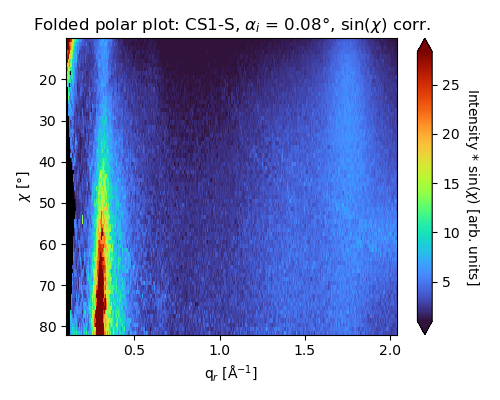

In [41]:
# Polar plots, for FOLDED sin(chi) intensities

# Set chi range: Full range
chi_min = 10
chi_max = 82
q_min = 0.1
q_max = 2.04

# Set savePath
savePath = outPath.joinpath('caked_plots_v1')

# selected_attrs_dict = {'incident_angle':['th0.080', 'th0.140']}
# selected_attrs_dict = {'material': ['PM6'], 'solvent': ['CFCN']}
selected_attrs_dict = {'sampleid': ['CS1-S']}
# selected_attrs_dict = {}

selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)    
for DA in tqdm(selected_DAs[:1]):
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max), qr=slice(q_min, q_max))
    
    # Set color limits
    real_min = float(sliced_DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min

    cmax = float(sliced_DA.compute().quantile(0.995))       
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(origin='upper', cmap=cmap, norm=plt.Normalize(cmin, cmax), figsize=(5,4))  # plot, optional parameter interpolation='antialiased' for image smoothing
    ax.axes.set(title=f'Folded polar plot: {DA.sampleid}, $\\alpha_i$ = {float(DA.incident_angle[2:])}°, sin($\chi$) corr.')
    ax.colorbar.set_label('Intensity * sin($\chi$) [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    # ax.figure.savefig(savePath.joinpath(f'sinchi-folded_{DA.sampleid}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)

    plt.show()  # Comment to mute plotting output
    # plt.close('all')

### 1D linecuts along chi

In [25]:
import matplotlib.ticker as ticker

In [26]:
import matplotlib.colors as mcolors

In [27]:
def darken_colors(color_array, factor):
    """
    Darken an array of RGB colors where 0 is white and 1 is black.
    
    :param color_array: An array of RGB colors in the range [0, 1] where 0 is white and 1 is black
    :param factor: A float between 0 and 1, where 0 has no change and 1 is fully black
    :return: The darkened color array
    """
    darkened_colors = color_array + (1 - color_array) * factor
    return np.clip(darkened_colors, 0, 1)  # Ensures values stay within valid range

In [29]:
# Set lims
oop_chi_min = 10
oop_chi_max = 30

ip_chi_min = 65
ip_chi_max = 82

q_min = 0.1
q_max = 2.04
# q_min = 0.2
# q_max = 0.8

# Set savePath
savePath = outPath.joinpath('stacked_linecut_plots_v1')

# selected_attrs_dict = {'incident_angle':['th0.080', 'th0.140'],
#                        'material':['Y6']}
# selected_attrs_dict = {'material':['Y7']}
selected_attrs_dict = {}

# group_size = 2
group_size = 4

selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)
DA_sublists = [selected_DAs[i:i + group_size] for i in range(0, len(selected_DAs), group_size)]

# colors = plt.cm.tab20c_r(np.linspace(0,1,20))[:16][::2]  # for 2 incident angles
colors = plt.cm.tab20c_r(np.linspace(0,1,20))[:16]  # for 4 incident angles
colors = darken_colors(colors, -0.5)

for DA_sublist in tqdm(DA_sublists):
    # Sort by incident angle:
    DA_sublist = sorted(DA_sublist, key = lambda x: x.incident_angle)
    
    # Define the figure and subplots
    fig, axs = plt.subplots(4, 1, figsize=(6, 8), sharex=True, dpi=120)

    # Adjust the spacing between plots
    fig.subplots_adjust(hspace=0.005)  # Adjust this value as needed to minimize white space
    
    for i, DA in enumerate(DA_sublist):        
        # Plotting each line in its subplot
        # OOP
        OOP_linecut_DA = DA.sel(chi=slice(oop_chi_min, oop_chi_max), qr=slice(q_min,q_max)).integrate('chi') / np.abs(oop_chi_max - oop_chi_min)
        OOP_linecut_DA.plot.line(color=colors[i], ax=axs[0], label=f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')

        # Diagonal
        Diagonal_linecut_DA = DA.sel(chi=slice(oop_chi_max, ip_chi_min), qr=slice(q_min,q_max)).integrate('chi') / np.abs(ip_chi_min - oop_chi_max)
        # Diagonal_linecut_DA.plot.line(color=colors[i+2], ax=axs[1], label=f'Diagonal, {oop_chi_max}-{ip_chi_min}°' + r' $\chi$, ' + f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')
        Diagonal_linecut_DA.plot.line(color=colors[i+4], ax=axs[1], label=f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')

        # IP
        IP_linecut_DA = DA.sel(chi=slice(ip_chi_min, ip_chi_max), qr=slice(q_min,q_max)).integrate('chi') / np.abs(ip_chi_max - ip_chi_min)
        # IP_linecut_DA.plot.line(color=colors[i+4], ax=axs[2], label=f'In-plane, {ip_chi_min}-{ip_chi_max}°' + r' $\chi$, ' + f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')
        IP_linecut_DA.plot.line(color=colors[i+8], ax=axs[2], label=f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')

        # Full
        Full_linecut_DA = DA.sel(chi=slice(oop_chi_min, ip_chi_max), qr=slice(q_min,q_max)).integrate('chi') / 90
        # Full_linecut_DA.plot.line(color=colors[i+6], ax=axs[3], label=f'Full, {oop_chi_min}-{ip_chi_max}°' + r' $\chi$, ' + f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')
        Full_linecut_DA.plot.line(color=colors[i+12], ax=axs[3], label=f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')

    # Add legends and gridlines to each subplot
    for ax in axs:
        ax.grid(True, which='major', axis='x')  # Add gridlines
        ax.xaxis.set_major_locator(ticker.AutoLocator())  # Set major tick locator
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Set minor tick locator
        ax.set_ylabel('')

    axs[0].text(0.5, 0.88, f'Out-of-plane, {oop_chi_min}-{oop_chi_max}°' + r' $\chi$', fontsize=12,
                horizontalalignment='center', transform=axs[0].transAxes)
    axs[1].text(0.5, 0.88, f'Diagonal, {oop_chi_max}-{ip_chi_min}°' + r' $\chi$', fontsize=12,
                horizontalalignment='center', transform=axs[1].transAxes)
    axs[2].text(0.5, 0.88, f'In-plane, {ip_chi_min}-{ip_chi_max}°' + r' $\chi$', fontsize=12,
                horizontalalignment='center', transform=axs[2].transAxes)
    axs[3].legend(loc='upper center', title=f'Full, {oop_chi_min}-{ip_chi_max}°' + r' $\chi$',
                  fontsize=10, title_fontsize='large')
       

    # Add axis labels
    axs[-1].set_xlabel('$q_r$ $[Å^{-1}]$', fontsize=12)
    fig.text(0.01, 0.5, 'Integrated intensities [arb. units]', va='center', rotation='vertical', fontsize=12)

    fig.suptitle(f'{DA.sampleid} $\\chi$-integrated linecuts, $\\chi$-width normed', y=0.91, fontsize=14)

    fig.savefig(savePath.joinpath(f'sinchi-folded_{DA.sampleid}_q{q_min}to{q_max}.png'), dpi=150, bbox_inches='tight')

    # plt.show()
    plt.close('all')

  0%|          | 0/18 [00:00<?, ?it/s]

In [30]:
# # Set lims
# oop_chi_min = 8
# oop_chi_max = 30

# ip_chi_min = 65
# ip_chi_max = 87

# q_min = 0.1
# q_max = 2.04

# # Set savePath
# # savePath = outPath.joinpath('PM6-Y6series/var/linecut_plots_v1')
# savePath = outPath.joinpath('PM6-Y6series/fix/linecut_plots_v1')

# # selected_attrs_dict = {'incident_angle':['th0.080', 'th0.140']}
# selected_attrs_dict = {}

# selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)
# for DA in tqdm(selected_DAs[:1]):
#     # OOP
#     OOP_linecut_DA = DA.sel(chi=slice(oop_chi_min, oop_chi_max), qr=slice(q_min,q_max)).integrate('chi')
#     OOP_linecut_DA.plot.line(figsize=(6,4), label=f'Out-of-plane, {oop_chi_min} to {oop_chi_max}°' + r' $\chi$')

#     # A plot.line xarray plot does not return an AxesImage object like imshow does
#     # Can use plt.gca() and plt.gcf() to access the axes & figure parameters
#     ax = plt.gca()
#     fig = plt.gcf()

#     # IP
#     ax2 = ax.twinx()
#     IP_linecut_DA = DA.sel(chi=slice(ip_chi_min, ip_chi_max), qr=slice(q_min,q_max)).integrate('chi')
#     IP_linecut_DA.plot.line(color='C1', ax=ax2, label=f'In-plane, {ip_chi_min} to {ip_chi_max}°' + r' $\chi$')
    
#     # ax.set(title=f'{DA.material} {DA.solvent} {DA.rpm} 22° Linecuts, {float(DA.incident_angle[2:])}° Incidence',
#     #        ylabel='Out-of-plane Intensity [arb. units]', xlabel='q$_r$ [Å$^{-1}$]')
#     ax.set(title=f'{DA.material} {DA.solvent} 22° Linecuts, {float(DA.incident_angle[2:])}° Incidence',
#            ylabel='Out-of-plane Intensity [arb. units]', xlabel='q$_r$ [Å$^{-1}$]')
#     ax2.set(ylabel='In-plane Intensity [arb. units]')
    
#     ax.grid(visible=True, which='major', axis='x')
#     fig.set(tight_layout=True, dpi=130)
#     ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1))
#     ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 0.91)) 
    
#     # ax.figure.savefig(savePath.joinpath(f'sinchi-folded_{DA.material}-{DA.solvent}-{DA.rpm}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
#     # ax.figure.savefig(savePath.joinpath(f'sinchi-folded_{DA.material}-{DA.solvent}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)

#     plt.show()
#     plt.close('all')

### 1D line fitting*
Use lmfit to perform the linefits

In [ ]:
from scipy import optimize, signal
from lmfit import models

In [ ]:
def fit_plotter(q, I, out):
    """
    Plots a figure with 2 axes, the full fit on a log scale on the left and the components in normal scale on the right
    """
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set(size_inches=(12,4))
    
    ax1.plot(q, I, label='data')
    ax1.plot(q, out.best_fit, label='full_fit')
    ax1.set(xlabel='Q [Å$^{-1}$]', ylabel='Intensity [arb. units]')
    ax1.legend(loc='upper left')
    
    ax2.plot(q, I, label='data')
    ax2.plot(q, out.best_fit, label='full_fit')
    for key in out.eval_components():
        ax2.plot(q, out.eval_components()[key], label=f'{key}')
    ax2.set(xlabel='Q [Å$^{-1}$]')
    ax2.legend(loc='upper left')
    
    return (ax1, ax2), fig

In [ ]:
# chi_min = 8
# chi_max = 18

# q_min = 1.1
# q_max = 2.45

# # points_x = [0.3, 2.6]

# point_x = q_min


# for DA in folded_corr_DAs:
#     point_y = float(DA.sel(chi=slice(chi_min, chi_max), qr=slice(point_x-0.01, point_x+0.01)).mean('qr').mean('chi'))
#     point_y = point_y - point_y*(0.08)


#     DA.sel(chi=slice(chi_min, chi_max), qr=slice(q_min, q_max)).plot()
#     plt.show()

#     OOP_linecut_DA = DA.sel(chi=slice(chi_min, chi_max), qr=slice(q_min, q_max)).mean('chi')
#     OOP_linecut_DA.plot()

#     plt.hlines(point_y, xmin=q_min, xmax=q_max)

#     plt.show()
#     plt.close('all')

In [ ]:
DA = selected_DAs[0].compute()
OOP_linecut_DA = DA.sel(chi=slice(chi_min, chi_max), qr=slice(q_min, q_max)).mean('chi')

point_x = q_min
point_y = float(DA.sel(chi=slice(chi_min, chi_max), qr=slice(point_x-0.01, point_x+0.01)).mean('qr').mean('chi'))
point_y = point_y - point_y*(0.08)

x = OOP_linecut_DA.qr.data
y = OOP_linecut_DA.data

#### Messy line fitting below

In [ ]:
# A1
intensity_type = 'raw'
if intensity_type == 'corr':
    DA = selected_corr_DAs[0].compute()
elif intensity_type == 'raw':
    DA = selected_raw_DAs[0].compute()
else:
    print('Must select intensity type')

OOP_linecut_DA = DA.sel(chi=slice(chi_min, chi_max), qr=slice(0.3, 1.9)).mean('chi')

point_x = 0.3
point_y = float(DA.sel(chi=slice(chi_min, chi_max), qr=slice(point_x-0.01, point_x+0.01)).mean('qr').mean('chi'))
point_y = point_y - point_y*(0.08)

x = OOP_linecut_DA.qr.data
y = OOP_linecut_DA.data

# Define all models to include in fitting
bkg_mod = models.LinearModel(prefix='bkg_')
pars = bkg_mod.make_params()
pars = bkg_mod.make_params(intercept=point_y, slope=0)
pars['bkg_intercept'].set(vary=False)
pars['bkg_slope'].set(vary=False)

pk1_mod = models.PseudoVoigtModel(prefix='pk1_')
# pars = pk1_mod.make_params(center=0.55)
pars += pk1_mod.guess(y, x, center=0.55)
# pars['pk1_amplitude'].set(min=0.5)
pars['pk1_amplitude'].set(min=0)

# pk2_mod = models.LorentzianModel(prefix='pk2_')
pk2_mod = models.PseudoVoigtModel(prefix='pk2_')

pars += pk2_mod.guess(y, x, center=1.7)
# pars['pk2_center'].set(max = 0.62, min = 0.58)
# pars['pk2_sigma'].set(max = 0.03)
pars['pk2_amplitude'].set(min=0)

pk3_mod = models.PseudoVoigtModel(prefix='pk3_')
pars += pk3_mod.guess(y, x, center=0.8)
pars['pk3_center'].set(max=0.9, min = 0.7)
pars['pk3_amplitude'].set(min=0)


# Combine into full model
mod = bkg_mod + pk1_mod + pk2_mod + pk3_mod

# Run fit and store all info in a ModelResult object
out = mod.fit(y, pars, x=x)
FWHM = np.round(float(out.params['pk2_fwhm']), 2)
center = np.round(float(out.params['pk2_center']), 2)
Lc = np.round((2*np.pi*0.9)/FWHM, 2)

# Plot
axs, fig = fit_plotter(x, y, out)
fig.set(tight_layout=True)

if intensity_type == 'corr':
    axs[0].set(ylabel=f'Meaned (Intensity * sin($\chi$)) [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, sin($\chi$)-corrected Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')    
elif intensity_type =='raw':
    axs[0].set(ylabel=f'Meaned Raw Intensity [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, Raw Intensity Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')

fig.savefig(outPath.joinpath('A1-3set_waxs/linecut_fits', f'{DA.film}_{intensity_type}_{DA.incident_angle}_{chi_min}to{chi_max}chi.png'), dpi=120)
plt.show()


print(f'FWHM = {FWHM}, Lc = {Lc}\n')
display(out.best_values)

In [ ]:
# A2
intensity_type = 'corr'
if intensity_type == 'corr':
    DA = selected_corr_DAs[1].compute()
elif intensity_type == 'raw':
    DA = selected_raw_DAs[1].compute()
else:
    print('Must select intensity type')
    
OOP_linecut_DA = DA.sel(chi=slice(chi_min, chi_max), qr=slice(0.3, 1.9)).mean('chi')

point_x = 0.3
point_y = float(DA.sel(chi=slice(chi_min, chi_max), qr=slice(point_x-0.01, point_x+0.01)).mean('qr').mean('chi'))
point_y = point_y - point_y*(0.08)

x = OOP_linecut_DA.qr.data
y = OOP_linecut_DA.data

# Define all models to include in fitting
bkg_mod = models.LinearModel(prefix='bkg_')
# pars = bkg_mod.make_params()
pars = bkg_mod.make_params(intercept=point_y, slope=0)
pars['bkg_intercept'].set(vary=False)
pars['bkg_slope'].set(vary=False)

pk1_mod = models.PseudoVoigtModel(prefix='pk1_')
# pars = pk1_mod.make_params(center=0.55)
pars += pk1_mod.guess(y, x, center=0.55)
# pars['pk1_amplitude'].set(min=0.5)

pk2_mod = models.PseudoVoigtModel(prefix='pk2_')
pars += pk2_mod.guess(y, x, center=1.7)
# pars['pk2_center'].set(max = 0.62, min = 0.58)
# pars['pk2_sigma'].set(max = 0.03)
# pars['pk2_amplitude'].set(min=0.5)

# Combine into full model
mod = bkg_mod + pk1_mod + pk2_mod

# Run fit and store all info in a ModelResult object
out = mod.fit(y, pars, x=x)
FWHM = np.round(float(out.params['pk2_fwhm']), 2)
center = np.round(float(out.params['pk2_center']), 2)
Lc = np.round((2*np.pi*0.9)/FWHM, 2)

# Plot
axs, fig = fit_plotter(x, y, out)
fig.set(tight_layout=True)

if intensity_type == 'corr':
    axs[0].set(ylabel=f'Meaned (Intensity * sin($\chi$)) [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, sin($\chi$)-corrected Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')    
elif intensity_type =='raw':
    axs[0].set(ylabel=f'Meaned Raw Intensity [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, Raw Intensity Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')

# fig.savefig(outPath.joinpath('A1-3set_waxs/linecut_fits', f'{DA.film}_{intensity_type}_{DA.incident_angle}_{chi_min}to{chi_max}chi.png'), dpi=120)
plt.show()

print(f'FWHM = {FWHM}, Lc = {Lc}\n')
display(out.best_values)

In [ ]:
# A3
intensity_type = 'raw'
if intensity_type == 'corr':
    DA = selected_corr_DAs[2].compute()
elif intensity_type == 'raw':
    DA = selected_raw_DAs[2].compute()
else:
    print('Must select intensity type')
    
OOP_linecut_DA = DA.sel(chi=slice(chi_min, chi_max), qr=slice(0.3, 1.9)).mean('chi')

point_x = 0.3
point_y = float(DA.sel(chi=slice(chi_min, chi_max), qr=slice(point_x-0.01, point_x+0.01)).mean('qr').mean('chi'))
point_y = point_y - point_y*(0.08)

x = OOP_linecut_DA.qr.data
y = OOP_linecut_DA.data

# Define all models to include in fitting
bkg_mod = models.LinearModel(prefix='bkg_')
# pars = bkg_mod.make_params()
pars = bkg_mod.make_params(intercept=point_y, slope=0)
pars['bkg_intercept'].set(vary=False)
pars['bkg_slope'].set(vary=False)

pk1_mod = models.PseudoVoigtModel(prefix='pk1_')
# pars = pk1_mod.make_params(center=0.55)
pars += pk1_mod.guess(y, x, center=0.55)
# pars['pk1_amplitude'].set(min=0.5)

pk2_mod = models.PseudoVoigtModel(prefix='pk2_')
pars += pk2_mod.guess(y, x, center=1.7)
# pars['pk2_center'].set(max = 0.62, min = 0.58)
# pars['pk2_sigma'].set(max = 0.03)
# pars['pk2_amplitude'].set(min=0.5)

# Combine into full model
mod = bkg_mod + pk1_mod + pk2_mod

# Run fit and store all info in a ModelResult object
out = mod.fit(y, pars, x=x)
FWHM = np.round(float(out.params['pk2_fwhm']), 2)
center = np.round(float(out.params['pk2_center']), 2)
Lc = np.round((2*np.pi*0.9)/FWHM, 2)

# Plot
axs, fig = fit_plotter(x, y, out)
fig.set(tight_layout=True)
FWHM = np.round(float(out.params['pk2_fwhm']), 2)
Lc = np.round((2*np.pi*0.9)/FWHM, 2)

if intensity_type == 'corr':
    axs[0].set(ylabel=f'Meaned (Intensity * sin($\chi$)) [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, sin($\chi$)-corrected Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')    
elif intensity_type =='raw':
    axs[0].set(ylabel=f'Meaned Raw Intensity [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, Raw Intensity Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')

fig.savefig(outPath.joinpath('A1-3set_waxs/linecut_fits', f'{DA.film}_{intensity_type}_{DA.incident_angle}_{chi_min}to{chi_max}chi.png'), dpi=120)
plt.show()

print(f'FWHM = {FWHM}, Lc = {Lc}\n')
display(out.best_values)


### Pole Figures

#### Pi-pi 

  0%|          | 0/72 [00:00<?, ?it/s]

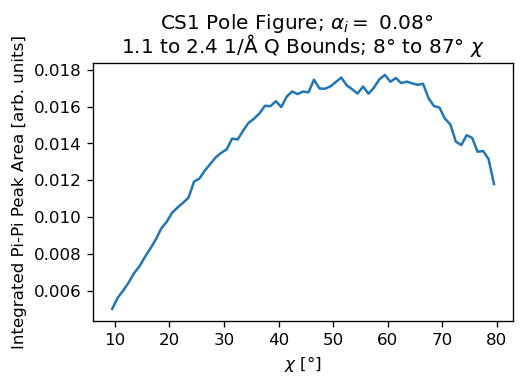

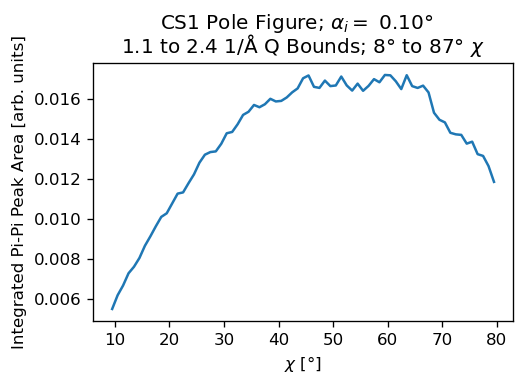

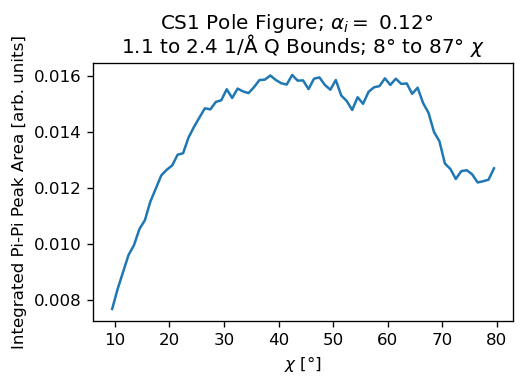

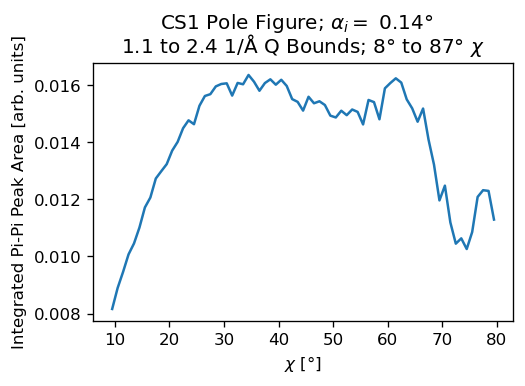

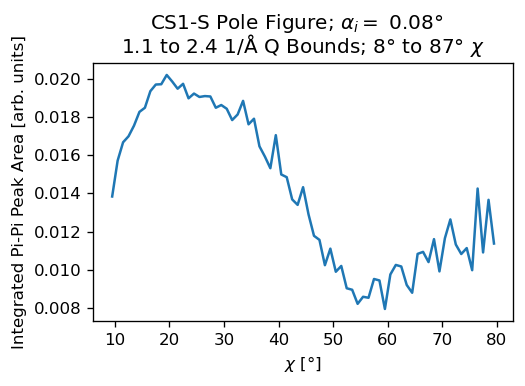

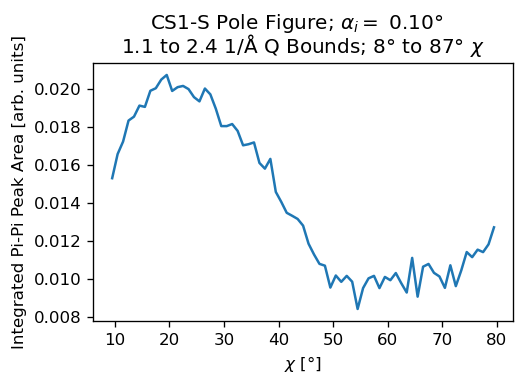

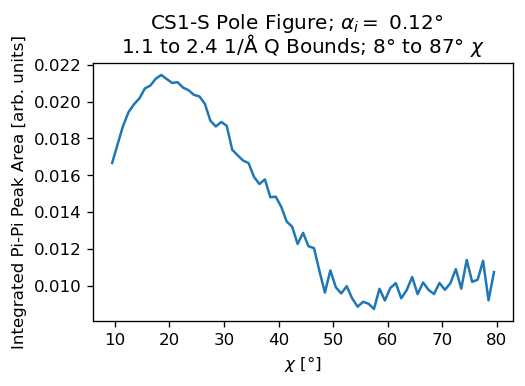

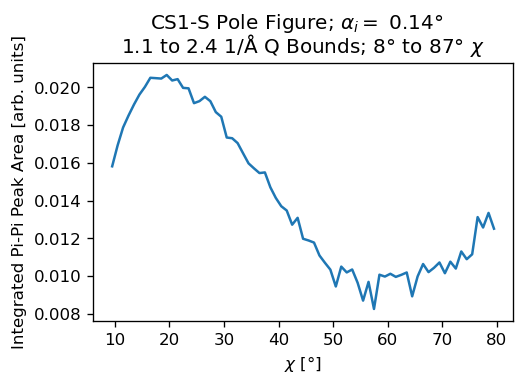

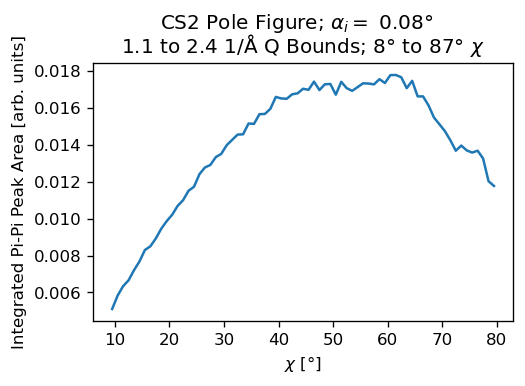

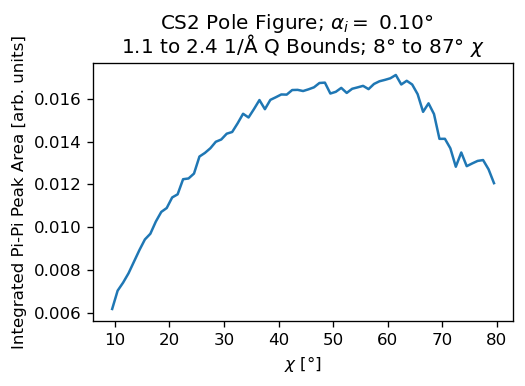

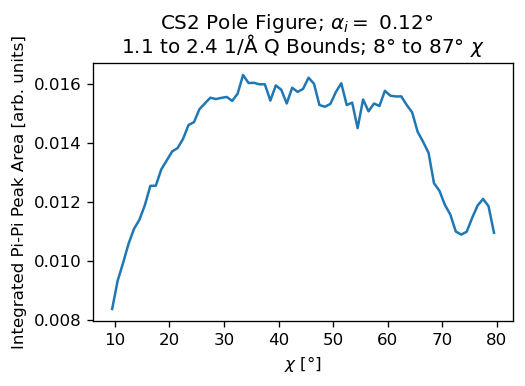

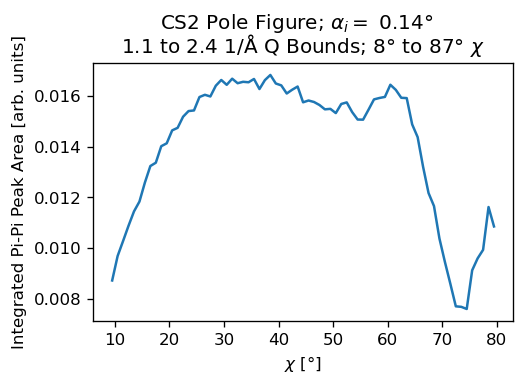

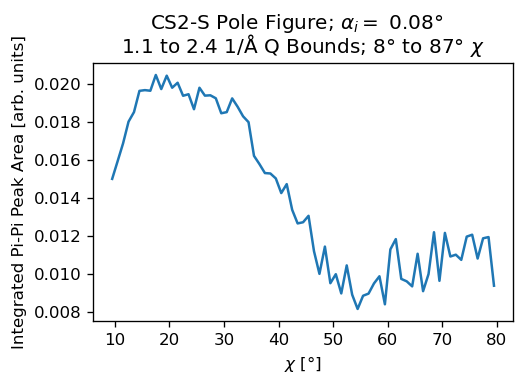

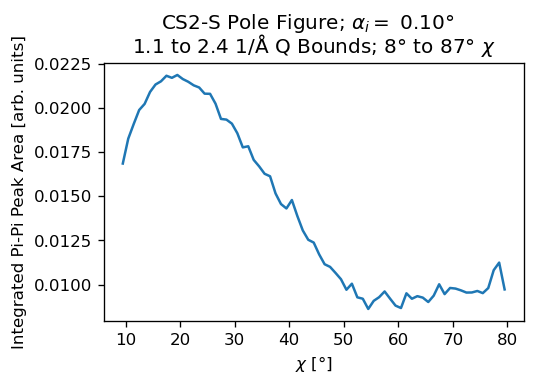

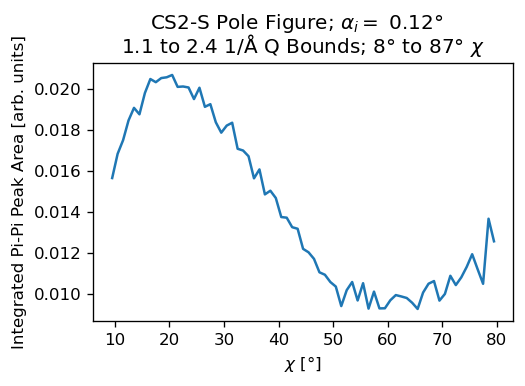

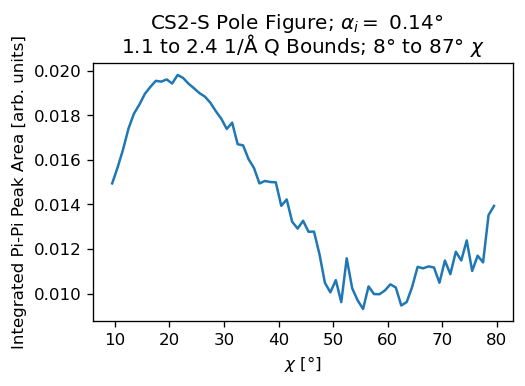

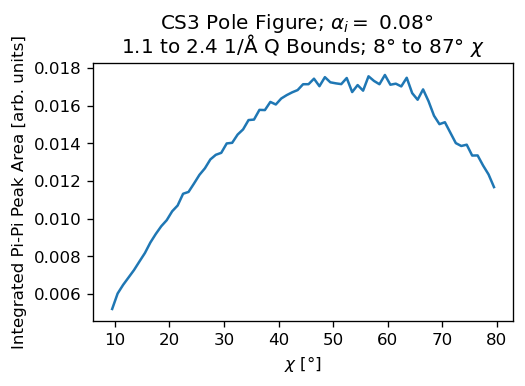

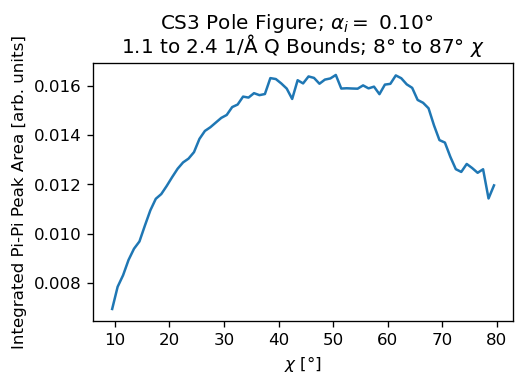

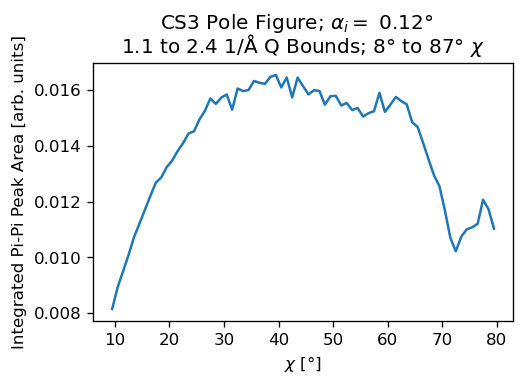

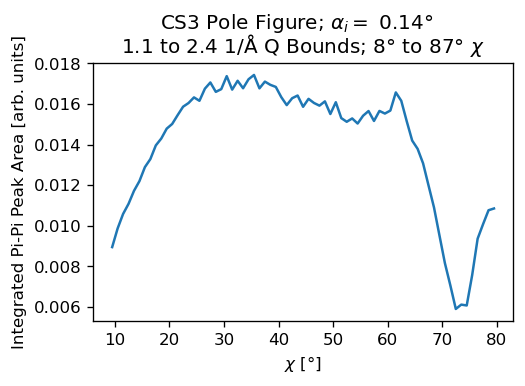

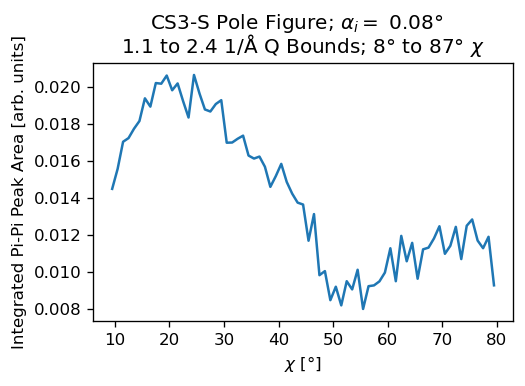

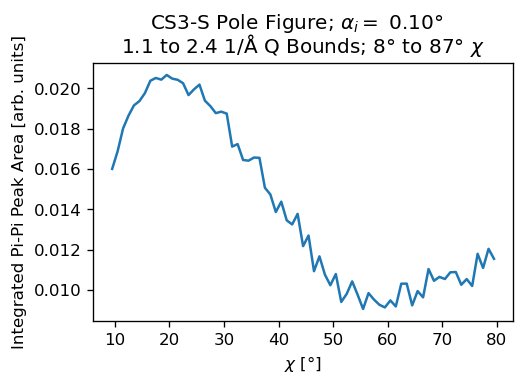

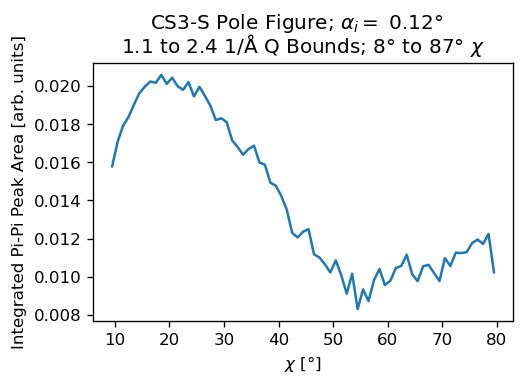

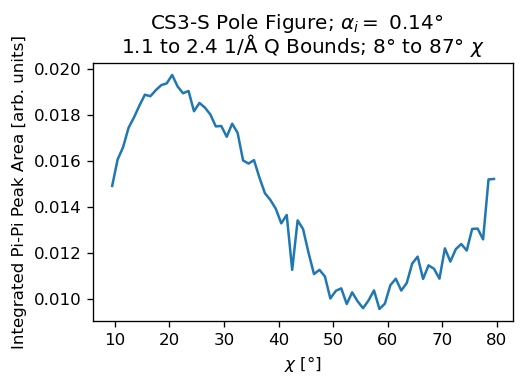

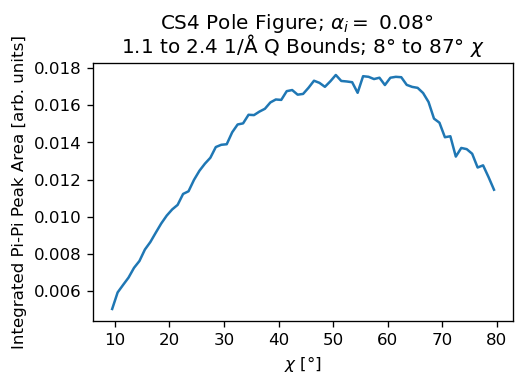

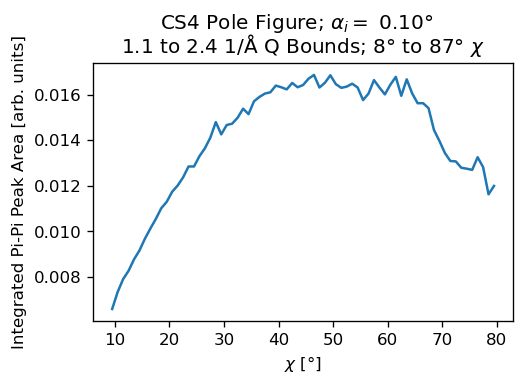

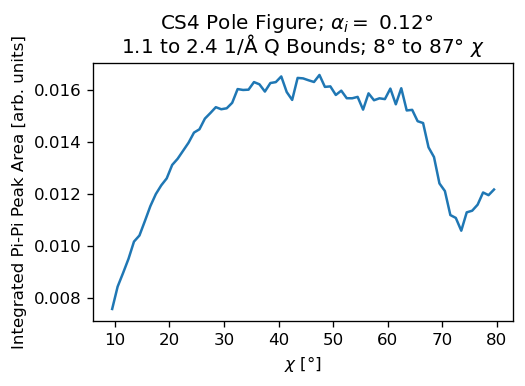

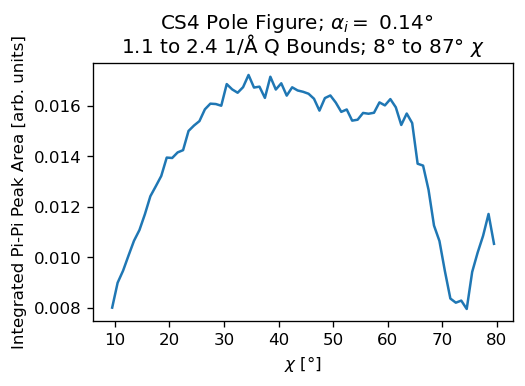

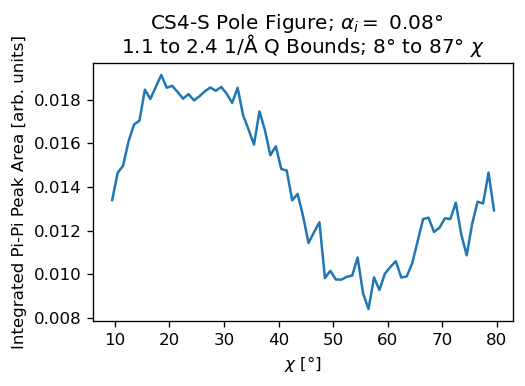

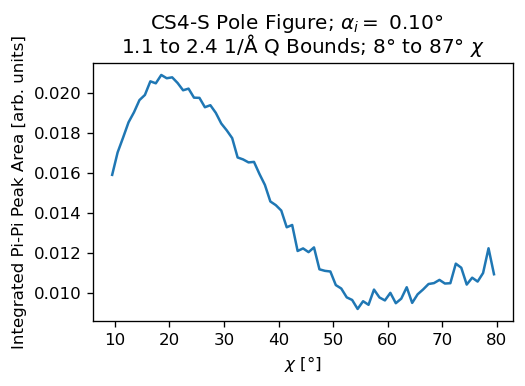

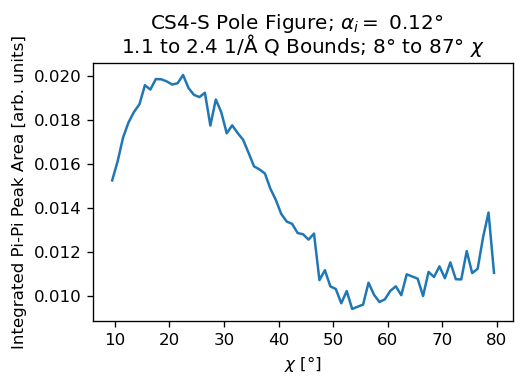

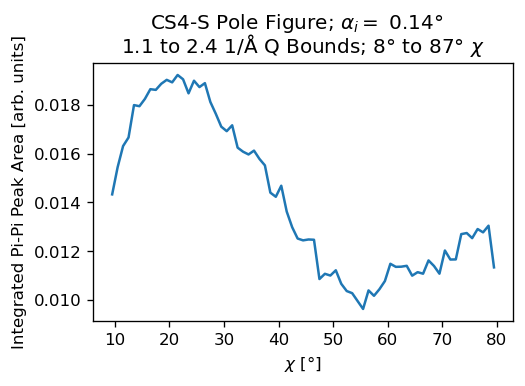

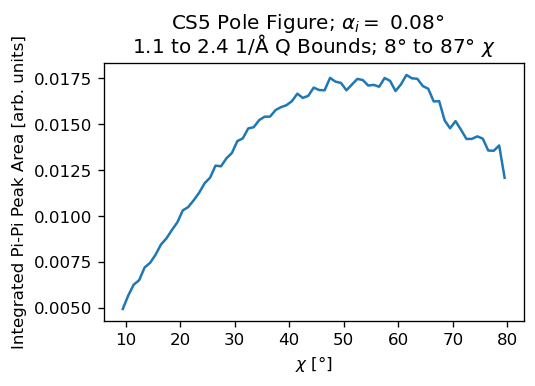

Exception ignored in: <function tqdm.__del__ at 0x2b24d4b04040>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tqdm/std.py", line 1144, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [53]:
### Set limits
q_min = 1.1
q_max = 2.4
chi_min = 8
chi_max = 87  # to ~45 least until I mask out the silicon(?) background scattering that interferes

# Set savePath
savePath = outPath.joinpath('pipi_pole_figures_v1')

selected_attrs_dict = {}

selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)
peak_areas_dict = {}    
for DA in tqdm(selected_DAs):
    chis = DA.chi.sel(chi=slice(chi_min,chi_max)).data
    
    peak_areas = np.array([])
    peak_centers = np.array([])
    
    for chi in chis:
        sliced_DA = DA.sel(qr=slice(q_min, q_max), chi=float(chi))

        points_x = [q_min+0.05, q_max-0.05]
        points_y = [float(sliced_DA.sel(qr=slice(points_x[0]-0.05, points_x[0]+0.05)).mean('qr')), 
                    float(sliced_DA.sel(qr=slice(points_x[1]-0.2, points_x[1]+0.2)).mean('qr'))]
        m = (points_y[1]-points_y[0])/(points_x[1]-points_x[0])
        b = points_y[1] - (m*points_x[1])
        y_fit = np.polyval([m, b], sliced_DA.qr)
        
        sub_sliced_DA = sliced_DA-y_fit

        peak_area = sub_sliced_DA.sel(qr=slice(1.5,1.8)).integrate('qr')
        peak_area = np.nan if peak_area<0 else peak_area  # remove negatives as they are nonphysical
        
        peak_areas = np.append(peak_areas, float(peak_area))
                        
#         # Plot linecuts for each chi
#         fig, ax = plt.subplots()
#         sliced_DA.plot(ax=ax)
#         ax.plot(points_x, points_y)
#         plt.show()

#         plt.close('all')

    normed_peak_areas = peak_areas / np.nansum(peak_areas)
    data = np.vstack((chis, normed_peak_areas)).T
    # peak_areas_dict[DA.attrs['material']+'-'+DA.attrs['solvent']+'-'+DA.attrs['rpm']+'-'+DA.attrs['incident_angle']] = data
    peak_areas_dict[DA.attrs['sampleid']+'-'+DA.attrs['incident_angle']] = data

    # Individual measurement pole figure plot
    fig, ax = plt.subplots(figsize=(5,3.3))
    fig.set(dpi=120)
    
    ax.plot(chis, normed_peak_areas)
    fig.suptitle(f'{DA.sampleid} Pole Figure; $\\alpha_i = $ {DA.incident_angle[2:-1]}°', x=0.54)
    ax.set(title=f'{q_min} to {q_max} 1/Å Q Bounds; {chi_min}° to {chi_max}° $\chi$')
    ax.set(xlabel='$\chi$ [°]', ylabel='Integrated Pi-Pi Peak Area [arb. units]')
    plt.subplots_adjust(top=0.85, bottom=0.2, left=0.2)
    
    # fig.savefig(savePath.joinpath(f'{DA.sampleid}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)

    plt.show()
    
    plt.close('all')

In [ ]:
### Set savePath
# savePath = outPath.joinpath('PM6-Y6series/var/pipi_pole_figures_v1')
savePath = outPath.joinpath('PM6-Y6series/fix/pipi_pole_figures_v1')

for th in tqdm(['th0.080', 'th0.100', 'th0.120', 'th0.140']):
    selected_dict_items = [(name, data) for (name, data) in peak_areas_dict.items() if 
                           # # 'Y7BO-' in name and
                           # 'CF' in name and '3000' in name and 
                           # th in name]    
                           'CFCN-' in name]    


    fig, ax = plt.subplots(figsize=(5,3.3))
    fig.set(dpi=120)
    
    colors = plt.cm.Dark2(np.linspace(0,1,len(selected_dict_items)))

    for i, (measurement, pole_fig_arr_data) in enumerate(selected_dict_items):
        chis = pole_fig_arr_data[:,0]
        normed_peak_areas = pole_fig_arr_data[:,1]
        ax.plot(chis, normed_peak_areas, color=colors[i], label=measurement)
        fig.suptitle('Pole Figure', x=0.55)
        ax.set(title=f'{q_min} to {q_max} 1/Å Q Fit Region; {chi_min}° to {chi_max}° $\chi$')
        ax.set(xlabel='$\chi$ [°]', ylabel='Normalized Peak Area')
    
    plt.subplots_adjust(top=0.85, bottom=0.2, left=0.2)
    ax.legend()
    
    # fig.savefig(savePath.joinpath(f'multiple-Y6_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-Y6BO_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-Y7_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-Y7BO_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    
    # fig.savefig(savePath.joinpath(f'multiple-CB3000_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-CB2000_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-CBCN_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-CF3000_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-CF2000_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-CFCN_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    
    # fig.savefig(savePath.joinpath(f'multiple-PM6_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-PM6-CB_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-PM6-CBCN_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-PM6-CF_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    fig.savefig(savePath.joinpath(f'multiple-PM6-CFCN_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    
    plt.show()
    plt.close('all')

#### Lamella

In [55]:
### Set limits
q_min = 0.2
q_max = 0.45
chi_min = 2
chi_max = 87  # to ~45 least until I mask out the silicon(?) background scattering that interferes

# Set savePath
savePath = outPath.joinpath('lamella_pole_figures_v1')

selected_attrs_dict = {}
selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)
 
peak_areas_dict = {}    
for DA in tqdm(selected_DAs):
    chis = DA.chi.sel(chi=slice(chi_min,chi_max)).data
    
    peak_areas = np.array([])
    peak_centers = np.array([])
    
    for chi in chis:
        sliced_DA = DA.sel(qr=slice(q_min, q_max), chi=float(chi))

        points_x = [q_min, q_max]
        points_y = [float(sliced_DA.sel(qr=slice(points_x[0]-0.05, points_x[0]+0.05)).mean('qr')), 
                    float(sliced_DA.sel(qr=slice(points_x[1]-0.05, points_x[1]+0.05)).mean('qr'))]
        # points_y = [float(sliced_DA.sel(qr=q_min, method='nearest')), 
        #             float(sliced_DA.sel(qr=q_max, method='nearest'))]
        m = (points_y[1]-points_y[0])/(points_x[1]-points_x[0])
        b = points_y[1] - (m*points_x[1])
        y_fit = np.polyval([m, b], sliced_DA.qr)
        
        sub_sliced_DA = sliced_DA-y_fit

        peak_area = sub_sliced_DA.sel(qr=slice(None,0.45)).integrate('qr')

        # peak_area = sliced_DA.sel(qr=slice(None,0.45)).integrate('qr')
        peak_area = np.nan if peak_area<0 else peak_area  # remove negatives as they are nonphysical
        
        peak_areas = np.append(peak_areas, float(peak_area))
                        
#         # Plot linecuts for each chi
#         fig, ax = plt.subplots()
#         sliced_DA.plot(ax=ax)
#         ax.plot(points_x, points_y)
#         plt.show()

#         plt.close('all')

    normed_peak_areas = peak_areas / np.nansum(peak_areas)
    data = np.vstack((chis, normed_peak_areas)).T
    # peak_areas_dict[DA.attrs['material']+'-'+DA.attrs['solvent']+'-'+DA.attrs['rpm']+'-'+DA.attrs['incident_angle']] = data
    peak_areas_dict[DA.attrs['sampleid']+'-'+DA.attrs['incident_angle']] = data


    # Individual measurement pole figure plot
    fig, ax = plt.subplots(figsize=(5,3.3))
    fig.set(dpi=120)
    
    ax.plot(chis, normed_peak_areas)
    fig.suptitle(f'{DA.sampleid} Pole Figure; $\\alpha_i = $ {DA.incident_angle[2:-1]}°', x=0.54)

    ax.set(title=f'{q_min} to {q_max} 1/Å Q Bounds; {chi_min}° to {chi_max}° $\chi$')
    ax.set(xlabel='$\chi$ [°]', ylabel='Integrated Pi-Pi Peak Area [arb. units]')
    plt.subplots_adjust(top=0.85, bottom=0.2, left=0.2)
    
    # fig.savefig(savePath.joinpath(f'{DA.material}-{DA.solvent}-{DA.rpm}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    
    # plt.show()
    
    plt.close('all')

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

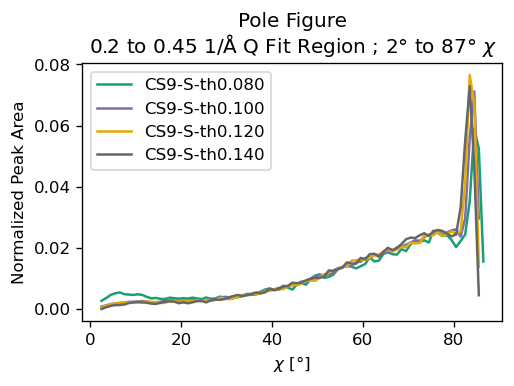

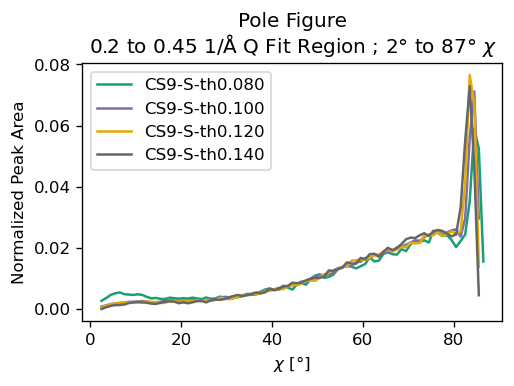

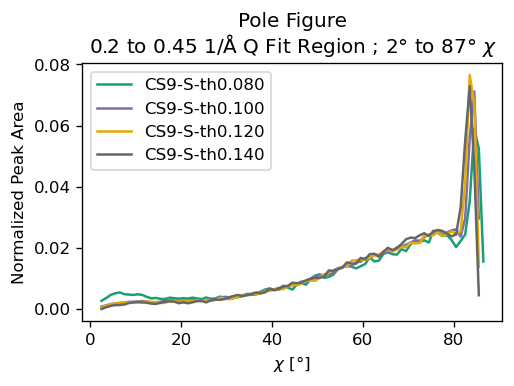

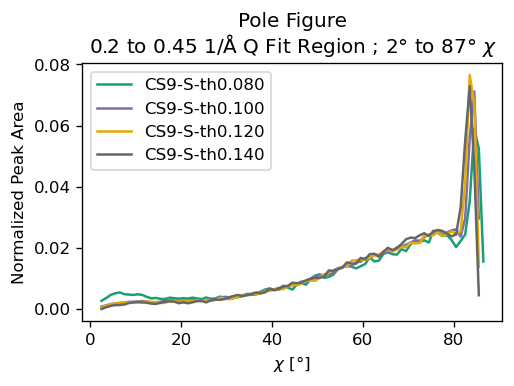

In [61]:
### Set savePath
# savePath = outPath.joinpath('PM6-Y6series/var/lamella_pole_figures_v1')
savePath = outPath.joinpath('PM6-Y6series/fix/lamella_pole_figures_v1')

for th in tqdm(['th0.080', 'th0.100', 'th0.120', 'th0.140']):
    selected_dict_items = [(name, data) for (name, data) in peak_areas_dict.items() if 
                           # # 'Y7BO-' in name and
                           # 'CF' in name and '3000' in name and 
                           # 'CS9-S' in name]     
                           # th in name] 

    fig, ax = plt.subplots(figsize=(5,3.3))
    fig.set(dpi=120)
    
    colors = plt.cm.Dark2(np.linspace(0,1,len(selected_dict_items)))

    for i, (measurement, pole_fig_arr_data) in enumerate(selected_dict_items):
        chis = pole_fig_arr_data[:,0]
        normed_peak_areas = pole_fig_arr_data[:,1]
        ax.plot(chis, normed_peak_areas, color=colors[i], label=measurement)
        fig.suptitle('Pole Figure', x=0.55)
        ax.set(title=f'{q_min} to {q_max} 1/Å Q Fit Region ; {chi_min}° to {chi_max}° $\chi$')
        ax.set(xlabel='$\chi$ [°]', ylabel='Normalized Peak Area')
    
    plt.subplots_adjust(top=0.85, bottom=0.2, left=0.2)
    ax.legend()
    
    # fig.savefig(savePath.joinpath(f'multiple-Y6_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-Y6BO_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-Y7_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-Y7BO_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)

    # fig.savefig(savePath.joinpath(f'multiple-CB3000_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-CB2000_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-CBCN_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-CF3000_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-CF2000_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-CFCN_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    
    # fig.savefig(savePath.joinpath(f'multiple-PM6_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-PM6-CB_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-PM6-CBCN_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-PM6-CF_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'multiple-PM6-CFCN_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)


    plt.show()
    plt.close('all')

# Original notebook code

### 2D plots

#### Caked Images

In [ ]:
filename = 'fix_caked_stitched.zarr'
DS = xr.open_zarr(zarrsPath.joinpath(filename))
DS = DS.where(DS>1e-5)
DS

In [ ]:
# # How one could apply a sin chi correction
# sin_chi_DA = np.sin(np.radians(np.abs(DA.chi)))
# # sin_chi_DA

# corr_DA = DA * sin_chi_DA
# # corr_DA

In [ ]:
# A way to select dataarrays based on attribute values:
selected_DAs = [da for da in DS.data_vars.values() if 
                da.attrs['material']]
                # da.attrs['material'] in ['Y6', 'Y7'] and 
                # da.attrs['incident_angle'] in ['th0.120', 'th0.140']]

len(selected_DAs)

In [ ]:
# Plot and optionally save selected dataarrays:
# Set chi range: Full range
chi_min = -90
chi_max = 90

for DA in tqdm(selected_DAs):
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max))
    
    # real_min = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 0.4)).compute().quantile(1e-3))
    real_min = float(DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min
    
    # cmax = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 2)).compute().quantile(1))   
    cmax = float(DA.compute().quantile(0.99))   
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), figsize=(5,4), interpolation='antialiased')  # plot, optional parameter interpolation='antialiased' for image smoothing
    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(title=f'Polar Plot: {DA.material} {DA.solvent}, {float(DA.incident_angle[2:])}° Incidence',
                xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    plt.show()  # Comment to mute plotting output
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    # ax.figure.savefig(outPath.joinpath('PM6-Y6set_waxs', f'polar-2D_{DA.sample_id}_{chi_min}to{chi_max}chi_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')

In [ ]:
# Plot and optionally save selected dataarrays:
# Set chi range: Full range
chi_min = -90
chi_max = 90

for DA in tqdm(selected_DAs):
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max))
    
    # real_min = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 0.4)).compute().quantile(1e-3))
    real_min = float(DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min
    
    # cmax = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 2)).compute().quantile(1))   
    cmax = float(DA.compute().quantile(0.999))   
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), figsize=(5,4), interpolation='antialiased')  # plot, optional parameter interpolation='antialiased' for image smoothing
    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(title=f'Polar Plot: {DA.material} {DA.solvent} {DA.rpm}, {float(DA.incident_angle[2:])}° Incidence',
                xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    plt.show()  # Comment to mute plotting output
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    # ax.figure.savefig(outPath.joinpath('PM6-Y6set_waxs', f'polar-2D_{DA.sample_id}_{chi_min}to{chi_max}chi_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')

In [ ]:
# Plot and optionally save selected dataarrays:
# Set chi range: In plane slice, choose a smooth section without detector gap/edge effects
chi_min = 72
chi_max = 82

for DA in tqdm(selected_DAs):
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max), qr=slice(0.23,2.05))
    cmin = float(sliced_DA.compute().quantile(1e-2))  # Set color minimum value, based on quantile 
    cmax = float(sliced_DA.compute().quantile(1-1e-6))  # Set color maximum value, based on quantile
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=LogNorm(cmin, cmax), figsize=(5,4))  # plot
    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(title=f'Polar Plot: {DA.sample_id}, {float(DA.incident_angle[2:])}° Incidence',
                xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    plt.show()  # Comment to mute plotting output
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    # ax.figure.savefig(outPath.joinpath('PM6-Y6set_waxs', f'polar-2D_{DA.sample_id}_{chi_min}to{chi_max}chi_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')

In [ ]:
# # A way to save data as csv files  
# for DA in DS.data_vars.values():
#     # qr columns, chi rows
#     DA.to_pandas().to_csv(outPath.joinpath('PM6-Y6_waxs', f'polar-2D_{DA.polymer}-{DA.weight_percent}_{DA.incident_angle}_{DA.scan_id}.csv'))

In [ ]:
filename = 'fix_raw_stitched.zarr'
DS = xr.open_zarr(zarrsPath.joinpath(filename))
DS = DS.where(DS>1e-6)
DS

In [ ]:
selected_DAs = [da for da in DS.data_vars.values() if 
                da.attrs['incident_angle']]
len(selected_DAs)

In [ ]:
# Plot & optionally save each selected polymer: fix data set
for DA in tqdm(selected_DAs):
    # Slice data for selected q ranges (will need to rename q_xy if dimensions are differently named)
    sliced_DA = DA.copy()
    sliced_DA = DA.sel(pix_y=slice(None, 680), pix_x=slice(150,None))

    # real_min = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 0.4)).compute().quantile(1e-3))
    real_min = float(DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min
    
    # cmax = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 2)).compute().quantile(1))   
    cmax = float(DA.compute().quantile(0.999))   
    
    # Same plotting procedure as above
    # ax = sliced_DA.plot.imshow(cmap=cmap, norm=LogNorm(cmin, cmax), interpolation='antialiased', figsize=(5.5,3.3))
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), interpolation='antialiased', figsize=(5.5,3.3),
                               origin='upper')

    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)
    ax.axes.set(title=f'Raw Detector: {DA.material} {DA.solvent}, {float(DA.incident_angle[2:])}° Incidence',
                aspect='equal')
    ax.figure.set(tight_layout=True, dpi=130)
    
    # ax.figure.savefig(outPath.joinpath('recip_plots/stitched_v2', f'{DA.material}_{DA.solvent}_{DA.incident_angle}.png'), dpi=120)
    plt.show()
    plt.close('all')

#### Reciprocal Space Images

In [ ]:
filename = 'var_recip_stitched.zarr'
DS = xr.open_zarr(zarrsPath.joinpath(filename))
DS = DS.where(DS>1e-6)
DS

In [ ]:
selected_DAs = [da for da in DS.data_vars.values() if 
                da.attrs['incident_angle']]
len(selected_DAs)

In [ ]:
# Plot & optionally save each selected polymer: fix data set
for DA in tqdm(selected_DAs):
    # Slice data for selected q ranges (will need to rename q_xy if dimensions are differently named)
    sliced_DA = DA.sel(q_xy=slice(-1.1, 2.1), q_z=slice(-0.01, 2.2))
    # sliced_DA = DA.sel(q_xy=slice(-0.5, -0.25), q_z=slice(1.5, 1.75))

    # real_min = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 0.4)).compute().quantile(1e-3))
    real_min = float(DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min
    
    # cmax = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 2)).compute().quantile(1))   
    cmax = float(DA.compute().quantile(0.999))   
    
    # Same plotting procedure as above
    # ax = sliced_DA.plot.imshow(cmap=cmap, norm=LogNorm(cmin, cmax), interpolation='antialiased', figsize=(5.5,3.3))
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), interpolation='antialiased', figsize=(5.5,3.3))

    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)
    ax.axes.set(title=f'Cartesian Plot: {DA.material} {DA.solvent}, {float(DA.incident_angle[2:])}° Incidence',
                aspect='equal', xlabel='q$_{xy}$ [Å$^{-1}$]', ylabel='q$_z$ [Å$^{-1}$]')
    ax.figure.set(tight_layout=True, dpi=130)
    
    ax.figure.savefig(outPath.joinpath('recip_plots/stitched_v2', f'{DA.material}_{DA.solvent}_{DA.incident_angle}.png'), dpi=120)
    # plt.show()
    plt.close('all')

In [ ]:
# Plot & optionally save each selected polymer: var data set
for DA in tqdm(selected_DAs):
    # Slice data for selected q ranges (will need to rename q_xy if dimensions are differently named)
    sliced_DA = DA.sel(q_xy=slice(-1.1, 2.1), q_z=slice(-0.01, 2.2))
    # sliced_DA = DA.sel(q_xy=slice(-0.5, -0.25), q_z=slice(1.5, 1.75))

    # real_min = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 0.4)).compute().quantile(1e-3))
    real_min = float(DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min
    
    # cmax = float(DA.sel(q_xy=slice(-0.5, -0.25), q_z=slice(0.1, 1.75)).compute().quantile(1-1e-10))   
    cmax = float(DA.compute().quantile(0.999))   
    
    # Same plotting procedure as above
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), interpolation='antialiased', figsize=(5.5,3.3))
    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)
    ax.axes.set(title=f'Cartesian Plot: {DA.material} {DA.solvent} {DA.rpm}, {float(DA.incident_angle[2:])}° Incidence',
                aspect='equal', xlabel='q$_{xy}$ [Å$^{-1}$]', ylabel='q$_z$ [Å$^{-1}$]')
    ax.figure.set(tight_layout=True, dpi=130)
    
    ax.figure.savefig(outPath.joinpath('recip_plots/stitched_v2', f'{DA.material}_{DA.solvent}_{DA.rpm}_{DA.incident_angle}.png'), dpi=120)
    # plt.show()
    plt.close('all')

In [ ]:
# # A way to save data as csv files
# for DA in tqdm(DS.data_vars.values()):
#     # qxy columns, qz rows
#     DA.to_pandas().to_csv(outPath.joinpath('PM6-Y6_waxs', f'cartesian-2D_{DA.polymer}-{DA.weight_percent}_{DA.incident_angle}_{DA.scan_id}.csv'))

### 1D Plots

In [ ]:
filename = 'caked_PM6-Y6_waxs_stitched.zarr'
DS = xr.open_zarr(samplesPath.joinpath(filename))
DS = DS.where(DS>1e-5)
DS

In [ ]:
selected_DAs = [da for da in DS.data_vars.values() if 
                da.attrs['incident_angle'] == 'th0.120']
len(selected_DAs)

In [ ]:
fpath = outPath.joinpath('PM6-Y6set_waxs', f'linecut_IP_{DA.polymer}-{DA.weight_percent}_{chi_min}to{chi_max}chi_{DA.incident_angle}.csv')
OOP_linecut_DA.to_dataframe('OOP Intensity').to_csv(fpath)

In [ ]:
# Plot linecuts for selected chi ranges, here I've put both in plane and out of plane selections into the loop

for DA in tqdm(DS.data_vars.values()):
    # OOP
    chi_min = -18
    chi_max = -8
    OOP_linecut_DA = DA.sel(chi=slice(chi_min, chi_max), qr=slice(0.14,2.01)).sum('chi')
    OOP_linecut_DA.plot.line(figsize=(6,4))

    # A plot.line xarray plot does not return an AxesImage object like imshow does, so I use plt.gca() and plt.gcf() to access the axes & figure parameters
    ax = plt.gca()
    fig = plt.gcf()
    
    ax.set(title=f'OOP Linecut, {chi_min}° to {chi_max}° $\chi$: {DA.polymer}-{DA.weight_percent}, {float(DA.incident_angle[2:])}° Incidence',
           yscale='log', ylabel='Intensity [arb. units]', xlabel='q$_r$ [Å$^{-1}$]')
    ax.grid(visible=True, which='major', axis='x')
    fig.set(tight_layout=True, dpi=130)
    
    plt.show()
    fpath = outPath.joinpath('PM6-Y6set_waxs', f'linecut_OOP_{DA.polymer}-{DA.weight_percent}_{chi_min}to{chi_max}chi_{DA.incident_angle}.csv')
    print('Saving csv data...')
    OOP_linecut_DA.to_dataframe('OOP_Intensity').to_csv(fpath)
    print('Saved!')
    # fig.savefig(outPath.joinpath('bladecoated-set_waxs', f'linecut_OOP_{DA.polymer}-{DA.weight_percent}_{chi_min}to{chi_max}chi_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')
    
    # IP
    chi_min = 72
    chi_max = 82
    IP_linecut_DA = DA.sel(chi=slice(chi_min, chi_max), qr=slice(0.23,2.01)).sum('chi')
    IP_linecut_DA.plot.line(figsize=(6,4))  
    
    ax = plt.gca()
    fig = plt.gcf()
    
    ax.set(title=f'IP Linecut, {chi_min}° to {chi_max}° $\chi$: {DA.polymer}-{DA.weight_percent}, {float(DA.incident_angle[2:])}° Incidence',
           yscale='log', ylabel='Intensity [arb. units]', xlabel='q$_r$ [Å$^{-1}$]')
    ax.grid(visible=True, which='major', axis='x')
    fig.set(tight_layout=True, dpi=130)
    
    plt.show()
    fpath = outPath.joinpath('PM6-Y6set_waxs', f'linecut_IP_{DA.polymer}-{DA.weight_percent}_{chi_min}to{chi_max}chi_{DA.incident_angle}.csv')
    print('Saving csv data...')
    IP_linecut_DA.to_dataframe('IP_Intensity').to_csv(fpath)  
    print('Saved!')
    # fig.savefig(outPath.joinpath('PM6-Y6set_waxs', f'linecut_IP_{DA.polymer}-{DA.weight_percent}_{chi_min}to{chi_max}chi_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')
    